<a href="https://colab.research.google.com/github/PrashubhAtri/heterogeneousSNNs/blob/main/Baselines/SNNs/SurrogateGradients/2ClassSNNwithVoltage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirements and Imports

In [1]:
! pip install snntorch wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 4.0 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/fzenke/randman

Cloning into 'randman'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 104 (delta 16), reused 34 (delta 8), pack-reused 59 (from 1)
Receiving objects: 100% (104/104), 683.31 KiB | 7.04 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [3]:
import sys
sys.path.append('/content/randman')

In [4]:
import numpy as np
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import randman
from randman import Randman
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [5]:
# set device for the entire code
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Input Values

In [6]:
# Constants for data generation
nb_inputs  = 100
nb_hidden  = 100
nb_outputs = 2
nb_steps  = 200
batch_size = 32
n_samples = 1000
SEED = 42
dim_manifolds = 3

# Split into ttv sets
train, test, validation = 0.8, 0.1, 0.1

time_step = 1e-3

## Dataset Functions

In [7]:
"""
  Dataset Cell
"""

def standardize(x,eps=1e-7):
    # x's (which is actually y in the following code) shape will be [samples, units]
    # Therefore, 0-axis shows that the author standardize across all samples for each units
    mi,_ = x.min(0)
    ma,_ = x.max(0)
    return (x-mi)/(ma-mi+eps)

def make_spiking_dataset(nb_classes=10, nb_units=100, nb_steps=100, step_frac=1.0, dim_manifold=2, nb_spikes=1, nb_samples=1000, alpha=2.0, shuffle=True, classification=True, seed=None):
    """ Generates event-based generalized spiking randman classification/regression dataset.
    In this dataset each unit fires a fixed number of spikes. So ratebased or spike count based decoding won't work.
    All the information is stored in the relative timing between spikes.
    For regression datasets the intrinsic manifold coordinates are returned for each target.
    Args:
        nb_classes: The number of classes to generate
        nb_units: The number of units to assume
        nb_steps: The number of time steps to assume
        step_frac: Fraction of time steps from beginning of each to contain spikes (default 1.0)
        nb_spikes: The number of spikes per unit
        nb_samples: Number of samples from each manifold per class
        alpha: Randman smoothness parameter
        shuffe: Whether to shuffle the dataset
        classification: Whether to generate a classification (default) or regression dataset
        seed: The random seed (default: None)
    Returns:
        A tuple of data,labels. The data is structured as numpy array
        (sample x event x 2 ) where the last dimension contains
        the relative [0,1] (time,unit) coordinates and labels.
    """

    data = []
    labels = []
    targets = []

    if SEED is not None:
        np.random.seed(SEED)

    max_value = np.iinfo(int).max
    randman_seeds = np.random.randint(max_value, size=(nb_classes,nb_spikes) )

    for k in range(nb_classes):
        x = np.random.rand(nb_samples,dim_manifold)

        # The following code shows that if more than one spike, different spikes, even for the same unit, are generated by independent mappings
        submans = [ randman.Randman(nb_units, dim_manifold, alpha=alpha, seed=randman_seeds[k,i]) for i in range(nb_spikes) ]
        units = []
        times = []
        for i,rm in enumerate(submans):
            y = rm.eval_manifold(x)
            y = standardize(y)
            units.append(np.repeat(np.arange(nb_units).reshape(1,-1),nb_samples,axis=0))
            times.append(y.numpy())

        units = np.concatenate(units,axis=1)
        times = np.concatenate(times,axis=1)
        events = np.stack([times,units],axis=2)
        data.append(events)
        labels.append(k*np.ones(len(units)))
        targets.append(x)

    data = np.concatenate(data, axis=0)
    labels = np.array(np.concatenate(labels, axis=0), dtype=int)
    targets = np.concatenate(targets, axis=0)

    if shuffle:
        idx = np.arange(len(data))
        np.random.shuffle(idx)
        data = data[idx]
        labels = labels[idx]
        targets = targets[idx]

    data[:,:,0] *= nb_steps*step_frac
    # data = np.array(data, dtype=int)

    if classification:
        return data, labels
    else:
        return data, targets

def events_to_spike_train(data):
    """convert the data generated from manifold to spike train form

    Args:
        data (array): shape is [samples, nb_events, 2]

    Returns:
        spike_train: shape is [nb_samples, nb_time_steps, units]
    """

    # astyle() will discard the decimal to give integer timestep
    spike_steps = data[:, :, 0].astype(int)
    spike_units = data[:, :, 1].astype(int)
    # These will be the indices to entrices in the spike train to be set to 1

    # Use the index on spike train matrix [samples, steps, units]
    spike_train = np.zeros((data.shape[0], nb_steps, nb_inputs))
    sample_indicies = np.expand_dims(np.arange(data.shape[0]), -1)
    spike_train[sample_indicies, spike_steps, spike_units] = 1

    return spike_train
def get_randman_dataset(outputs, inputs, steps, dim, seed, samplesperclass):
    """generate a TensorDataset encapsulated x and y, where x is spike trains

    Returns:
        TensorDataset: [nb_samples, time_steps, units] and [nb_samples]
    """
    data, label = make_spiking_dataset(nb_classes=outputs, nb_units=inputs, nb_steps=steps, dim_manifold=dim, seed=seed, nb_samples=samplesperclass)
    spike_train = events_to_spike_train(data)

    spike_train = torch.Tensor(spike_train).to(device)
    label = torch.Tensor(label).to(device)

    # encapulate using Torch.Dataset
    dataset = TensorDataset(spike_train, label)

    return dataset

In [8]:
def split_dataset(spike_trains, train, test, val, shuffle):
    all_labels = [spike_trains[i][1] for i in range(len(spike_trains))]

    # First split: train (80%) and temp (20%)
    train_idx, temp_idx = train_test_split(
        np.arange(len(spike_trains)),
        test_size=test,
        # stratify=all_labels,
        random_state=SEED,
        shuffle=shuffle
    )

    # Second split: val (10%) and test (10%) from temp
    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=0.5,
        # stratify=[all_labels[i] for i in temp_idx],
        random_state=SEED,
        shuffle=shuffle
    )

    from torch.utils.data import Subset
    train_dataset = Subset(spike_trains, train_idx)
    val_dataset = Subset(spike_trains, val_idx)
    test_dataset = Subset(spike_trains, test_idx)

    #Batch_size = 32
    batch_size = 32

    train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    train_labels = [spike_trains[i][1] for i in train_dataset.indices]
    test_labels = [spike_trains[i][1] for i in test_dataset.indices]
    val_labels = [spike_trains[i][1] for i in val_dataset.indices]

    return train_loader, test_loader, val_loader, train_labels, test_labels, val_labels, train_idx, test_idx, val_idx

## Dataset Generation Function

In [9]:
spike_trains = get_randman_dataset(nb_outputs, nb_inputs, nb_steps, dim_manifolds, SEED, n_samples)

In [10]:
train_loader, test_loader, val_loader, train_labels, test_labels, val_labels, train_idx, test_idx, val_idx = split_dataset(spike_trains, train, test, validation, False)

## Auxillary dataset check

In [11]:
sample, label = spike_trains[0]  # Access the first sample
print(f"Sample shape: {sample.shape}")
print(f"Label: {label}")

Sample shape: torch.Size([200, 100])
Label: 1.0


In [12]:
len(spike_trains)

2000

In [13]:
len(train_idx), len(val_idx), len(test_idx)

(1800, 100, 100)

In [14]:
# Example: Iterate through the training DataLoader
for batch_data, batch_labels in train_loader:
    print(f"Batch data shape: {batch_data.shape}")
    print(f"Batch labels: {batch_labels}")
    break

Batch data shape: torch.Size([32, 200, 100])
Batch labels: tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
        0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.])


In [15]:
len(test_loader), len(train_loader), len(val_loader)

(4, 57, 4)

In [16]:
# Visualize class distribution
from collections import Counter
labels = [int(label) for label in train_labels]
print(Counter(labels))
labels = [int(label) for label in test_labels]
print(Counter(labels))
labels = [int(label) for label in val_labels]
print(Counter(labels))

Counter({1: 903, 0: 897})
Counter({0: 55, 1: 45})
Counter({1: 52, 0: 48})


## Model Desription and Loss Functions

In [17]:
class SNN(nn.Module):
    def __init__(self, num_inputs=nb_inputs, num_hidden=nb_hidden, num_outputs=nb_outputs, beta=0.95, surrogate_slope = 100):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=surrogate_slope))

        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=surrogate_slope), reset_mechanism="none")

        # Xavier Uniform Initialization for Stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # import pdb; pdb.set_trace()
        batch_size, time_steps, num_neurons = x.shape
        x = x.permute(1, 0, 2)  # (time, batch, neurons)
        x = x.to(device)

        mem1 = torch.zeros(batch_size, self.fc1.out_features, device=x.device)
        mem2 = torch.zeros(batch_size, self.fc2.out_features, device=x.device)


        mem2_rec = []

        for t in range(time_steps):
            spk1, mem1 = self.lif1(self.fc1(x[t]), mem1)
            _, mem2 = self.lif2(self.fc2(spk1), mem2)
            mem2_rec.append(mem2)

        return torch.stack(mem2_rec, dim=0)  # (time_steps, batch_size, num_outputs)

In [18]:
def multiclassMembraneMarginLoss(mem, labels):
    """
    mem: Tensor of shape [batch_size, num_classes, time_steps]
    labels: Tensor of shape [batch_size]
    """
    batch_size, num_classes, time_steps = mem.shape
    labels = labels.long()

    # Get the membrane potentials for the correct classes: [batch_size, time_steps]
    correct_class_potentials = mem[torch.arange(batch_size), labels, :]  # [batch_size, time_steps]

    # Expand for broadcasting: [batch_size, 1, time_steps]
    correct_class_potentials = correct_class_potentials.unsqueeze(1)

    # Subtract correct potentials from all class potentials
    diff = mem - correct_class_potentials  # [batch_size, num_classes, time_steps]

    # Mask out the correct class
    mask = torch.ones_like(diff, dtype=torch.bool)
    mask[torch.arange(batch_size), labels, :] = False

    # Apply the mask
    diff_masked = diff[mask].view(batch_size, num_classes - 1, time_steps)

    # Hinge activation: penalize only when wrong class > correct
    diff_activated = torch.where(diff_masked > 0, diff_masked, torch.zeros_like(diff_masked))

    # Average over all samples, wrong classes, and time steps
    return diff_activated.mean()


## Model and optimiser

In [19]:
# Initialize model, loss, and optimizer
model = SNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)


## Pretraining Plots

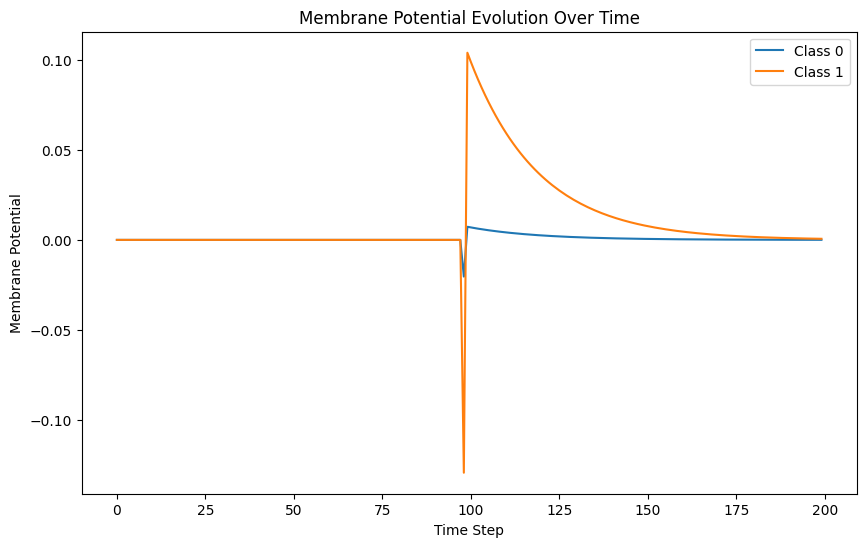

In [20]:
import matplotlib.pyplot as plt

# Select a batch for visualization
inputs, labels = next(iter(test_loader))
# inputs = torch.ones([1,100,100])
mem_out = model(inputs)  # (time_steps, batch_size, num_outputs)

# Select first sample in the batch
mem_potentials = mem_out[:, 0, :].cpu().detach().numpy()  # Shape: (time_steps, num_outputs)
time_steps = mem_potentials.shape[0]
num_classes = mem_potentials.shape[1]

# Plot membrane potential over time for each output class
plt.figure(figsize=(10, 6))
for class_idx in range(num_classes):
    plt.plot(range(time_steps), mem_potentials[:, class_idx], label=f"Class {class_idx}")

plt.xlabel("Time Step")
plt.ylabel("Membrane Potential")
plt.title("Membrane Potential Evolution Over Time")
plt.legend()
plt.show()

## Training Loop

In [21]:
# Training Loop
num_epochs = 7
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in tqdm(train_loader, total = len(train_loader)):
        # import pdb; pdb.set_trace()
        optimizer.zero_grad()
        mem_out = model(inputs)  # Shape: (time_steps, batch_size, num_outputs)


        # mem_out = mem_out.permute(1,2, 0)
        # mem_out = torch.max(mem_out, dim = -1)[0]


        # labels = labels.long()
        # loss = criterion(mem_out, labels)

        mem_out = mem_out.permute(1, 2, 0)
        loss = multiclassMembraneMarginLoss(mem_out, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        mem_out_aux = torch.max(mem_out, dim = -1)[0]
        predicted = torch.argmax(mem_out_aux, dim=1)
        total += labels.size(0)

        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # import pdb; pdb.set_trace()
            mem_out = model(inputs)
            # mem_out = mem_out.permute(1,2, 0)
            # mem_out = torch.max(mem_out, dim = -1)[0]
            # labels = labels.long()
            # loss = criterion(mem_out, labels)

            mem_out = mem_out.permute(1, 2, 0)
            loss = multiclassMembraneMarginLoss(mem_out, labels)
            val_loss += loss.item()

            mem_out_aux = torch.max(mem_out, dim = -1)[0]

            predicted = torch.argmax(mem_out_aux, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total

    # Save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Acc: {train_accuracy*100:.2f}% | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy*100:.2f}%")

# Load best model for testing
model.load_state_dict(torch.load('best_model.pth'))

# Testing Loop
model.eval()
test_loss, correct, total = 0.0, 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        mem_out = model(inputs)
        mem_out = mem_out.permute(1,2, 0)
        # mem_out = torch.max(mem_out, dim = -1)[0]
        # labels = labels.long()
        # loss = criterion(mem_out, labels)
        loss = multiclassMembraneMarginLoss(mem_out, labels)
        test_loss += loss.item()

        mem_out_aux = torch.max(mem_out, dim = -1)[0]

        predicted = torch.argmax(mem_out_aux, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = correct / total

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy*100:.2f}%")


100%|██████████| 57/57 [00:17<00:00,  3.25it/s]


Epoch [1/7]
Train Acc: 80.00% | Train Loss: 0.0062 | Val Loss: 0.0032 | Val Acc: 94.00%


100%|██████████| 57/57 [00:18<00:00,  3.11it/s]


Epoch [2/7]
Train Acc: 96.22% | Train Loss: 0.0025 | Val Loss: 0.0034 | Val Acc: 97.00%


100%|██████████| 57/57 [00:16<00:00,  3.36it/s]


Epoch [3/7]
Train Acc: 97.33% | Train Loss: 0.0020 | Val Loss: 0.0005 | Val Acc: 98.00%


100%|██████████| 57/57 [00:17<00:00,  3.33it/s]


Epoch [4/7]
Train Acc: 98.83% | Train Loss: 0.0014 | Val Loss: 0.0010 | Val Acc: 99.00%


100%|██████████| 57/57 [00:17<00:00,  3.29it/s]


Epoch [5/7]
Train Acc: 99.28% | Train Loss: 0.0008 | Val Loss: 0.0002 | Val Acc: 100.00%


100%|██████████| 57/57 [00:17<00:00,  3.34it/s]


Epoch [6/7]
Train Acc: 99.28% | Train Loss: 0.0005 | Val Loss: 0.0005 | Val Acc: 100.00%


100%|██████████| 57/57 [00:17<00:00,  3.20it/s]


Epoch [7/7]
Train Acc: 99.50% | Train Loss: 0.0004 | Val Loss: 0.0005 | Val Acc: 100.00%


<ipython-input-21-d20bd1200e7c>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Results:
Test Loss: 0.0005 | Test Accuracy: 100.00%


## Output Layer Potentials

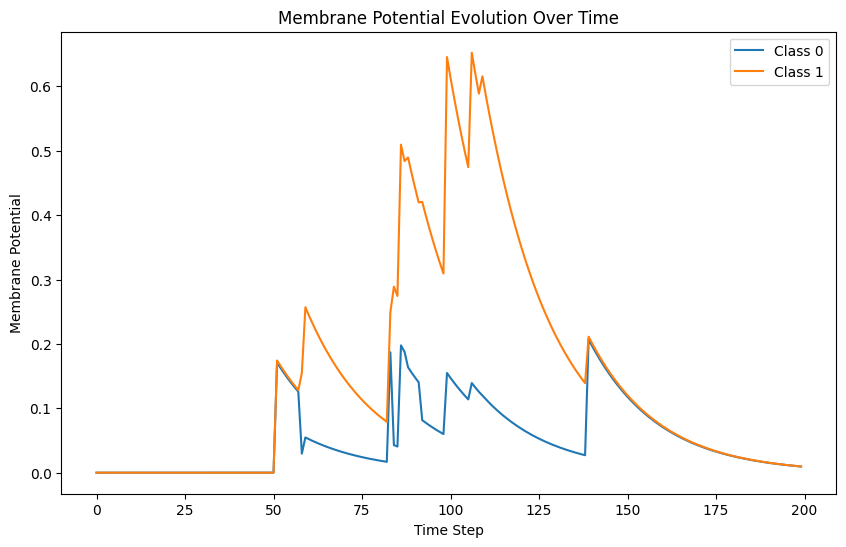

In [22]:
import matplotlib.pyplot as plt

# Select a batch for visualization
inputs, labels = next(iter(test_loader))
# inputs = torch.ones([1,100,100])
mem_out = model(inputs)  # (time_steps, batch_size, num_outputs)

# Select first sample in the batch
mem_potentials = mem_out[:, 0, :].cpu().detach().numpy()  # Shape: (time_steps, num_outputs)
time_steps = mem_potentials.shape[0]
num_classes = mem_potentials.shape[1]

# Plot membrane potential over time for each output class
plt.figure(figsize=(10, 6))
for class_idx in range(num_classes):
    plt.plot(range(time_steps), mem_potentials[:, class_idx], label=f"Class {class_idx}")

plt.xlabel("Time Step")
plt.ylabel("Membrane Potential")
plt.title("Membrane Potential Evolution Over Time")
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch


def plot_confusion_matrix(model, loader, device):
    model.eval()
    model.to(device)

    # Loop for classifying
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            # import pdb; pdb.set_trace()
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # shape: [batch_size, num_classes, time_steps]
            outputs = outputs.permute(1, 2, 0)
            outputs = torch.max(outputs, dim = -1)[0]

            predicted = torch.argmax(outputs, dim=1)  # predicted class
            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())

        # Concatenate all batches
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        # Convert to numpy
        y_true = all_labels.numpy()
        y_pred = all_preds.numpy()

        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix:\n", conf_matrix)

        # Full classification report (Precision, Recall, F1-score for each class)
        print("\nClassification Report:\n", classification_report(y_true, y_pred))

        # Overall accuracy
        print("\nAccuracy: ", accuracy_score(y_true, y_pred))

        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

Confusion Matrix:
 [[55  0]
 [ 0 45]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        55
         1.0       1.00      1.00      1.00        45

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


Accuracy:  1.0


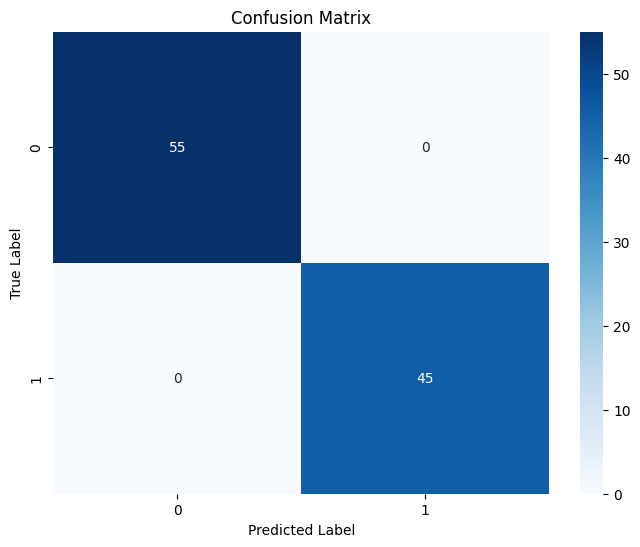

In [25]:
plot_confusion_matrix(model, test_loader, device)

In [23]:
model

SNN(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (lif2): Leaky()
)

In [ ]:
model.fc1.weight[0][0]

tensor(0.0285, grad_fn=<SelectBackward0>)

In [ ]:
class SNNS(nn.Module):
    def __init__(self, num_inputs=nb_inputs, num_hidden=100, num_outputs=nb_outputs, beta=0.95):
        super(SNNS, self).__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=100))

        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=100))

        # Xavier Uniform Initialization for Stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # import pdb; pdb.set_trace()
        batch_size, time_steps, num_neurons = x.shape
        x = x.permute(1, 0, 2)  # (time, batch, neurons)

        mem1, mem2 = [torch.zeros(batch_size, layer.out_features, device=x.device)
                      for layer in [self.fc1, self.fc2]]

        mem2_rec = []

        for t in range(time_steps):
            spk1, mem1 = self.lif1(self.fc1(x[t]), mem1)
            _, mem2 = self.lif2(self.fc2(spk1), mem2)
            mem2_rec.append(mem2)

        return torch.stack(mem2_rec, dim=0)  # (time_steps, batch_size, num_outputs)

In [ ]:
model = SNN()
# Load best model for testing
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device(device)))

# Testing Loop
model.eval()
test_loss, correct, total = 0.0, 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        mem_out = model(inputs)
        mem_out = mem_out.permute(1,2, 0)
        # mem_out = torch.max(mem_out, dim = -1)[0]
        # labels = labels.long()
        # loss = criterion(mem_out, labels)
        loss = losscustom(mem_out, labels)
        test_loss += loss.item()

        mem_out_aux = torch.max(mem_out, dim = -1)[0]

        predicted = torch.argmax(mem_out_aux, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = correct / total

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy*100:.2f}%")



Final Test Results:
Test Loss: 0.0068 | Test Accuracy: 99.00%


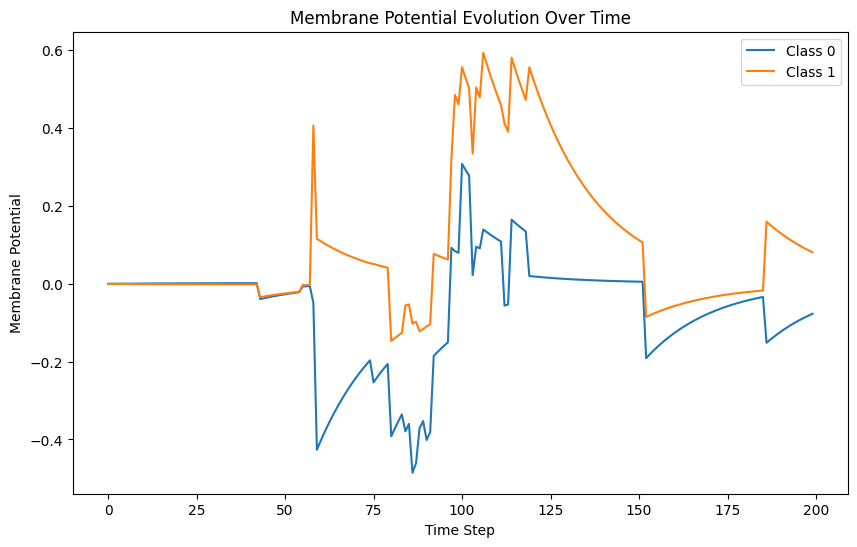

In [ ]:
import matplotlib.pyplot as plt

# Select a batch for visualization
inputs, labels = next(iter(test_loader))
# inputs = torch.ones([1,100,100])
mem_out = model(inputs)  # (time_steps, batch_size, num_outputs)

# Select first sample in the batch
mem_potentials = mem_out[:, 0, :].cpu().detach().numpy()  # Shape: (time_steps, num_outputs)
time_steps = mem_potentials.shape[0]
num_classes = mem_potentials.shape[1]

# Plot membrane potential over time for each output class
plt.figure(figsize=(10, 6))
for class_idx in range(num_classes):
    plt.plot(range(time_steps), mem_potentials[:, class_idx], label=f"Class {class_idx}")

plt.xlabel("Time Step")
plt.ylabel("Membrane Potential")
plt.title("Membrane Potential Evolution Over Time")
plt.legend()
plt.show()

In [ ]:
model

SNN(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (lif2): Leaky()
)

In [ ]:
# for batch in train_loader:
#     break

In [ ]:
# batch[0].shape, batch[1].shape

In [ ]:
# model_temp = SNN()

In [ ]:
# aux_out = model_temp(batch[0])

In [ ]:
# aux_out.shape
# aux_out= aux_out.permute(1, 2, 0)
# aux_out.shape

In [ ]:
# losscustom(aux_out, batch[1])

In [ ]:
# aux_out[torch.arange(aux_out.shape[0]), labels].shape

In [ ]:
# losscustom(aux_out, batch[1])

In [ ]:
# aux_out

In [ ]:
model

SNN(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (lif2): Leaky()
)